Viscoelastoplasticity in simple shear
======

**The momentum equation for a viscoelastic rheology**

Writing $\dot\tau$ as a finite difference, substituting into the strain rate equation above and solving for $\tau$ gives,

$$\tau_{ij}(t,x) = 2\eta_{eff}D_{ij}(t,x) + \frac{\eta_{eff}}{\mu\Delta t}\check{\tau}(t-\Delta t, x) \qquad \textrm(1)$$ 

where $\eta_{eff} = ( \eta \Delta t) / (\alpha + \Delta t)$ is an effective viscosity, $\alpha = \eta / \mu$ the Maxwell relaxation time, and $\check{\tau}$ is the stress history advectived and rotated into the current reference frame using the velocity field ${u}$. Substituting this viscoelastic stress definition into the conservation of momentum equation, defined as

$$ \sigma_{ij,j} = \tau_{ij,j} - p_i = f_i $$

where $\sigma$ is the total stress tensor, $p$ the isotropic pressure and $f$ the force term, gives

$$ ( 2 \eta_{\mathrm{eff}} D_{ij} )_{,j} - p_{,i} = f_i - \frac{\eta_{\mathrm{eff}}}{\mu\Delta t}\check{\tau}_{ij,j} $$

Thus, our implementation of viscosity elasticity, after [Moresi et al, 2003](http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1), modifies the momentum equation using an effective viscosity and additional force term dependent on material properties, time step size and stress history. The above viscoelastic momentum equation coupled with convervation of mass, $ u_{i,j}$ provides a solution for a Maxwell viscoelastic material deforming under the Boussinesq approximation for infiniti Prandtl, low Reynolds number incompressible flow. 

**visco-elastic model with a yield limit (visco-elastic-plastic)**

We want the stress to remain on the yield surface, and $|\tau| \equiv (\tau_{ij}\tau_{ij}/2)^{1/2}$. 

the effective viscosity for yielded material can be found directly using 

$$\eta_{\mathrm{vep}} = \tau_{yield} / |D_{\mathrm{eff}}|  \qquad \textrm(2)$$ 

with $|D| = (D_{ij}D_{ij}/2)^{1/2}$ and 

$$D_{\mathrm{eff}} = 2D^t + \frac{1}{\mu\Delta t_e}\tau^{t-1}    \qquad \textrm(3)$$ 


Substitution of $\eta_{\mathrm{vep}}$ into Eq 1. ressults in the visco-elastic-plastic stress being equal to the scalar yield stress value.

The iteration of $\eta$ is repeated until the velocity solution is unchanged to within an error tolerance required for the solution as a whole.

**Implementation order**

In this notebook, the following approach is taken:

1) first calcualte the 'normal' visco-elastic effective viscosity ($\eta_{\mathrm{eff}}$) using the background viscosity (constant in this example)

2) define the yielding viscocity ($\eta_{\mathrm{vep}}$) using Equation 2.

3) the final viscosity, which is provided to the Stokes system, is then defined as: 
$$min(\eta_{\mathrm{vep}}, \eta_{\mathrm{eff}})$$ 



Note that we don't need to explicity define where the material is yielding, this is simply determined by taking the minimum. 


**Simple shear in two dimensions**

This notebook models a viscoelastoplastic material, with a maximum yield strength of $\tau_y = 2.0$, undergoing simple shear in two dimensions. The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 1$.  For $t > 1$ the top wall velocity is taken to zero with the stored elastic stress allowed to relax.

In [136]:
import underworld as uw
from underworld import function as fn
import glucifer
uw.matplotlib_inline()

import matplotlib.pyplot as pyplot
pyplot.ion()  # don't hang on show() for pure python runs
import numpy as np
import math

import mpi4py
comm = mpi4py.MPI.COMM_WORLD
import os

In [137]:
# Paramters

#Model setup
#elementType = "Q2/dPc1"
elementType ="Q1/dQ0"
Res = 48



# Define material parameters

# define background material properties
eta_bg     = 1.0e-2
density_bg = 0.0

# define beam material properties
density = 1.
eta     = 1.0e2                            # viscosity
mu      = 1.0e2                            # elastic modulus
yieldStress = 1.0e2


#Elasticity and timestepping
alpha   = eta / mu                         # viscoelastic relaxation time
dt_e    = 0.1                              # elastic time step
num_step_factor = 0.1

dt_num = dt_e*num_step_factor              # max numerical timestep


#Telerance and stability
min_viscosity = 0.001
ksp_rtol = 1e-06                           #Relative decrease in residual norm
nl_tolerance = 1e-5                        #Non-linear tolerance

In [138]:
# create output directory
try:
    workdir
except NameError:
    workdir = os.path.abspath(".")

outputPath = os.path.join(workdir,"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [139]:
#Create mesh and finite element variables


mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (Res, Res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.),
                                 periodic    = [True, False]  ) 

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [140]:
# Apply velocity boundary conditions
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
leftWall = mesh.specialSets["MinI_VertexSet"]

# no slip on left wall, free slip on all others
cantileverBC = uw.conditions.DirichletCondition( variable       = velocityField, 
                                            indexSetsPerDof = ( iWalls, jWalls + iWalls) ) 

In [141]:
# create swarm
swarm         = uw.swarm.Swarm( mesh=mesh,  particleEscape=True)
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# add swarm variable
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

# add previous stress swarm variable to carry the stress history term
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]

# create tracer particle within beam
tracerSwarm = uw.swarm.Swarm( mesh=mesh )
tracerSwarm.add_particles_with_coordinates(np.array([(0.45,0.5)]))

array([0], dtype=int32)

In [142]:
#uw.swarm.Swarm?

In [143]:
# layout materials
background  = 0
beam        = 1

coord = fn.input()
conditions = [ (  (coord[1] > 0.44) 
                & (coord[1] < 0.56) 
                & (coord[0] < 0.5), beam),
               (             True , background ),
             ]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)


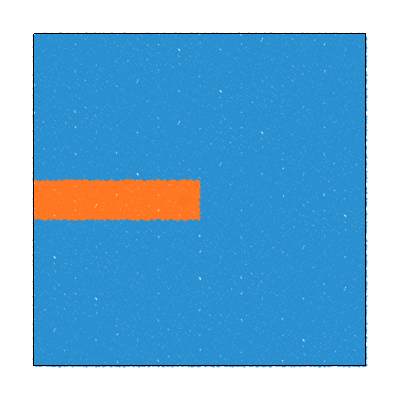

In [144]:
figsize=(400,400) 
figMaterial = glucifer.Figure( figsize=figsize )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0, colourBar=False) )
figMaterial.append( glucifer.objects.VectorArrows(mesh, velocityField) )
figMaterial.append( glucifer.objects.Points(tracerSwarm, pointSize=15.0) )

figMaterial.show()

In [145]:
# define strain rate tensor

strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [146]:
# map viscosity to material
mappingDictViscosity = { background : eta_bg, 
                               beam : eta }
viscosityMapFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictViscosity )

In [147]:

# viscoelastic effective viscosity
eta_eff = ( viscosityMapFn * dt_e ) / (alpha + dt_e)  # effective viscosity


# yield stress
yieldStressFn = fn.misc.constant(yieldStress)

In [148]:
# define viscoelastic effective strain rate

D_eff    = strainRate+0.5*previousStress/(mu*dt_e)
D_effInv = fn.math.sqrt(0.5*(D_eff[0]**2+D_eff[1]**2)+D_eff[2]**2)

# define viscosity at yield stress

min_viscosity = 0.001
yieldingViscosityFn = 0.5 * yieldStressFn / ( D_effInv + 1.0e-18 )  

# define viscosity function

viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, eta_eff), 
                                                   min_viscosity))


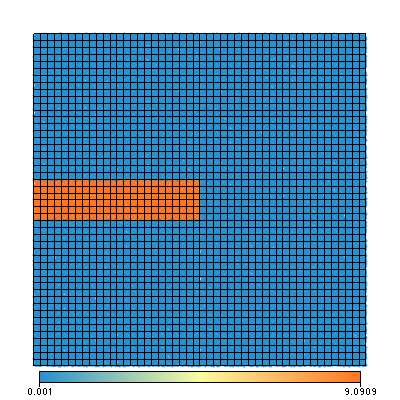

In [149]:
# plot viscosity 
figViscosity = glucifer.Figure( figsize=figsize )
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=4.0) )
figViscosity.append( glucifer.objects.Mesh(mesh))

figViscosity.show()

In [150]:
# define the viscoelastic stress tensor

viscousStressFn = 2. * viscosityFn * strainRate 

elasticStressFn = viscosityFn / ( mu * dt_e ) * previousStress
stressFn        = viscousStressFn + elasticStressFn


viscousStress_2nInvariant = fn.math.sqrt(0.5*(viscousStressFn[0]**2+viscousStressFn[1]**2)+viscousStressFn[2]**2)
elasticStress_2nInvariant = fn.math.sqrt(0.5*(elasticStressFn[0]**2+elasticStressFn[1]**2)+elasticStressFn[2]**2)
stress_2ndInvariant = fn.math.sqrt(0.5*(stressFn[0]**2+stressFn[1]**2)+stressFn[2]**2)



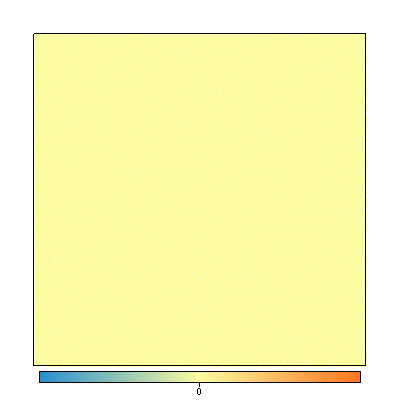

In [151]:
# plot xx-comp stress

figStressXX = glucifer.Figure( figsize=figsize )
figStressXX.append( glucifer.objects.Points(swarm, stressFn[0], pointSize=4.0) )
figStressXX.show()

In [152]:
# functions for calculating RMS velocity
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )


In [153]:
# density
mappingDictDensity = { background : density_bg,
                             beam : density }
densityFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictDensity )

# buoyancy force term
gravity = 1.
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityFn * gravity * z_hat

In [154]:
# create stokes system, solver and advector
stokes = uw.systems.Stokes( velocityField       = velocityField, 
                               pressureField    = pressureField,
                               voronoi_swarm     = swarm, 
                               conditions       = [cantileverBC,],
                               fn_viscosity     = viscosityFn, 
                               fn_bodyforce     = buoyancyFn,
                               fn_stresshistory = elasticStressFn)

solver   = uw.systems.Solver( stokes )

solver.options.scr.ksp_rtol = ksp_rtol

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
tracerAdvector = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )

In [155]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    #dt = advector.get_max_dt()
    # cap time step for observation time 
    #if dt > dt_num:
    dt = dt_num   # dt_e/10 for time to coincide with maxShearTime

    # Advect using this timestep size.
    advector.integrate(dt)
    tracerAdvector.integrate(dt)
        
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )
    
    return time+dt, step+1

In [156]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

deflection = tracerSwarm.particleCoordinates.data[0][1]


# save stress history for plotting
tTracer           = []
srTracer          = []   
vyTracer          = []
totalStress_xy    = [] 

point_eval = (0.5, 0.5)

In [157]:
# load beam until y = 0.4
while step < 10:
    # output for analysis               
    tTracer.append(time)
    # keep record of ...


    # solve stokes problem
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tolerance)
    
    #
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    # print model infi
    if( comm.rank ==0):
        if step%10 == 0:
            print time, step, deflection, stress_2ndInvariant.evaluate(swarm).max()\
            
    vyTracer.append(velocityField.evaluate(tracerSwarm)[0][0])
    srTracer.append(strainRate_2ndInvariant.evaluate(tracerSwarm)[0][0])
    totalStress_xy.append(stressFn[2].evaluate(swarm)[0])
    
    # We are finished with current timestep, update.
    time, step = update()
    
    
    


0.0 0 0.5 2.57587930913



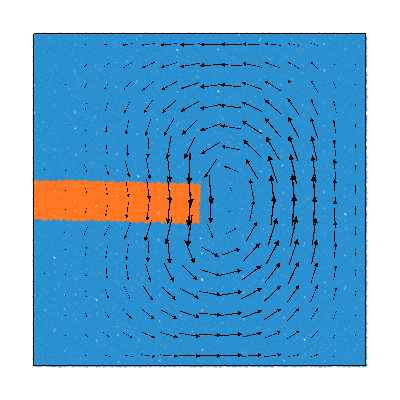

In [158]:
figMaterial.show()


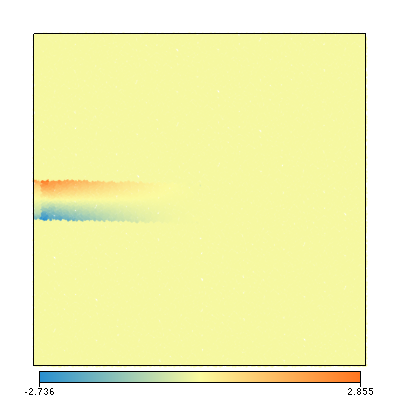

In [159]:

figStressXX.show()


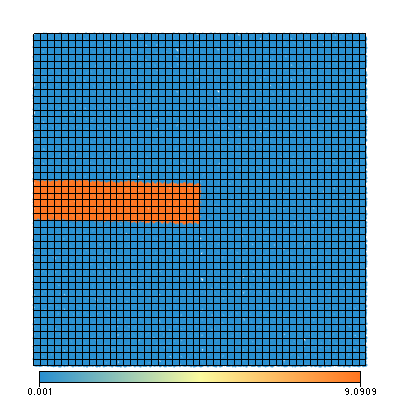

In [160]:
figViscosity.show()

In [161]:
import matplotlib.pyplot as plt

In [162]:
#vyTracer, tTracer

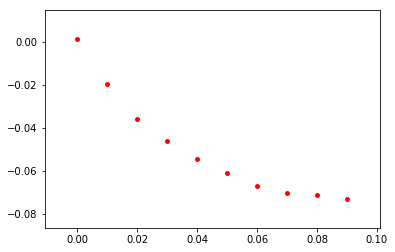

In [163]:
fig, ax = plt.subplots()

ax.scatter(tTracer, np.array(vyTracer)*50, s = 15, c = 'r')
#ax.scatter(tTracer, totalStress_xy, s = 15, c = 'k')

#ax.set_xlim(-0.1, 2.1)

#ax.set_ylim(-0.1, 0.2)

In [164]:
# re-build stokes - turn off buoyancy
stokesNew = uw.systems.Stokes( velocityField    = velocityField, 
                           pressureField     = pressureField,
                           #voronoi_swarm     = swarm, 
                           conditions        = [cantileverBC,],
                           fn_viscosity      = viscosityMapFn, 
                           fn_bodyforce      = None,
                           fn_stresshistory = elasticStressFn)

solverNew = uw.systems.Solver( stokesNew )

In [165]:
# allow elastic stresses to relax for 10 steps
nsteps = step+10
while step < nsteps:
    
    tTracer.append(time)
    # solve stokes problem
    solverNew.solve()          
    # update.
    time, step = update()
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    if step%10 == 0:            
        print step, time, deflection
        
        
    vyTracer.append(velocityField.evaluate(tracerSwarm)[0][0])
    srTracer.append(strainRate_2ndInvariant.evaluate(tracerSwarm)[0][0])
    totalStress_xy.append(stressFn[2].evaluate(swarm)[0])

20 0.2 0.490680909831



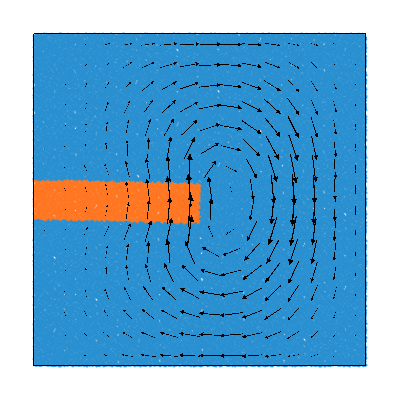

In [166]:
figMaterial.show()


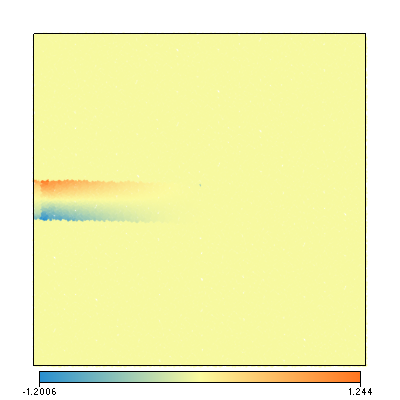

In [167]:
figStressXX.show()

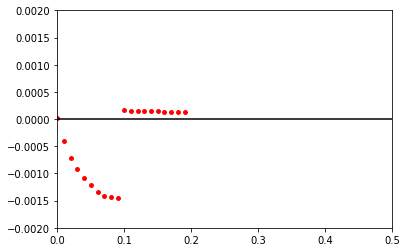

In [168]:
fig, ax = plt.subplots()

ax.scatter(tTracer, np.array(vyTracer), s = 15, c = 'r')


ax.set_ylim(-0.002, 0.002)
ax.set_xlim(0.0, 0.5)

ax.hlines(0, 0, 0.5)

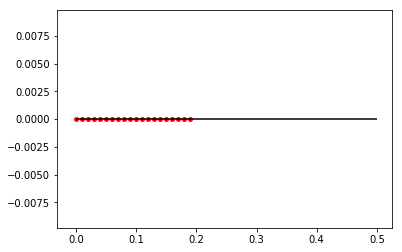

In [169]:
fig, ax = plt.subplots()

ax.scatter(tTracer, np.array(totalStress_xy), s = 15, c = 'r')


#ax.set_ylim(-0.002, 0.002)
#ax.set_xlim(0.0, 0.5)

ax.hlines(0, 0, 0.5)

In [171]:
#np.savetxt('saved_data/orig.csv', 
#          np.column_stack((tTracer,vyTracer)))

## Comparison

In [172]:
data_orig = np.loadtxt('saved_data/orig.csv')
data_orig_yield = np.loadtxt('saved_data/orig_yielding.csv')

data_alt = np.loadtxt('saved_data/alt.csv')
data_alt_yield = np.loadtxt('saved_data/alt_yielding.csv')

(0.0, 0.5)

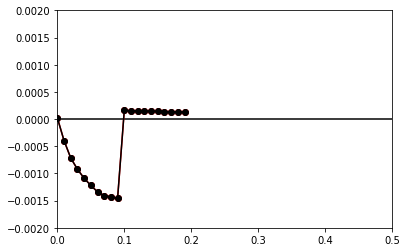

In [173]:
fig, ax = plt.subplots()

ax.plot(data_orig[:,0], 
            data_orig[:,1], c = 'r', marker = 'o')

ax.plot(data_alt[:,0], 
            data_alt[:,1], c = 'k', marker = 'o')


ax.hlines(0, 0, 0.5)

ax.set_ylim(-0.002, 0.002)
ax.set_xlim(0.0, 0.5)

(0.0, 0.5)

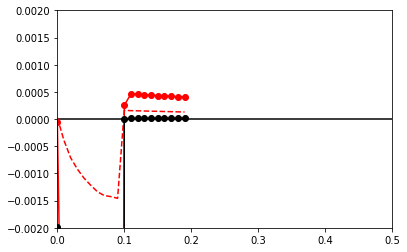

In [174]:
fig, ax = plt.subplots()


ax.plot(data_orig[:,0], 
            data_orig[:,1], c = 'r', ls = '--')

ax.plot(data_orig_yield[:,0], 
            data_orig_yield[:,1], c = 'r', marker = 'o')

ax.plot(data_alt_yield[:,0], 
            data_alt_yield[:,1], c = 'k', marker = 'o')


ax.hlines(0, 0, 0.5)

ax.set_ylim(-0.002, 0.002)
ax.set_xlim(0.0, 0.5)